# white-beam interferometry/tomography (March, 2017) Reconstruction with Tomopy/Astra modules

### Descriptions: fits folder is needed

In [40]:
path = "/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt6_AM_TENS_Horiz_3D_v1" #change your path here
absFitsFileName = 'FITS/'
darkFitsFileName = 'FITS/'
dpcFitsFileName = 'FITS/'
angleIncrement = 360/(200.0-1.0)
par = angleIncrement

## Step 1: Initialization

In [41]:
# -*- coding: utf-8 -*-
from __future__ import print_function
import tomopy
import os
from os import listdir
from os.path import isfile, join
import numpy  
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import string
from numpy.linalg import inv  #matrix calc
import math #log
import scipy
import scipy.ndimage
import scipy.signal #median filter for zero bad pixels
from astropy.io import fits #fits file read and writeTo
import re #sort fits files
from IPython.display import clear_output #clear output
import math

## Step 2: Functions

### Step 2.1: Read files

In [42]:
def readFile(path, string):   #search string "white" and "raw"
    allFiles = [f for f in listdir(path) if isfile(join(path,f))]  
    for n in range(0, len(allFiles)):
        allFiles[n] = join(path,allFiles[n])
    allFiles.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]) 
    #use "regular expression" to sort filenames
    listfile = [];
    for seq in range (0, len(allFiles)):
        if string in allFiles[seq]:
            listfile.append(allFiles[seq])
    print ('There are '+ str(len(listfile))+ ' '+ string + ' files')        
    return(listfile)

## Step 3: path, read files and filenames

### set path and filenames

In [43]:
workdir = path
absFITS = os.path.join(workdir, absFitsFileName)
darkFITS = os.path.join(workdir, darkFitsFileName)
dpcFITS = os.path.join(workdir, dpcFitsFileName)
print ('Your working directory is: ', workdir)
print (absFITS)

Your working directory is:  /run/media/tomouser/MercurySSD/HZB_Mar2017/Expt6_AM_TENS_Horiz_3D_v1
/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt6_AM_TENS_Horiz_3D_v1/FITS/


### read abs fits files and create abs volume

In [44]:
rotateAngle = -np.arctan(1/1024.0)*180.0 / np.pi
rotateAngle

-0.055952891893803668

There are 200 _abs_ files
/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt6_AM_TENS_Horiz_3D_v1/FITS/Expt6_AM_TENS_Horiz_3D_v1_abs_81.0.fits
Filename: /run/media/tomouser/MercurySSD/HZB_Mar2017/Expt6_AM_TENS_Horiz_3D_v1/FITS/Expt6_AM_TENS_Horiz_3D_v1_abs_81.0.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (1024, 600)   float64   


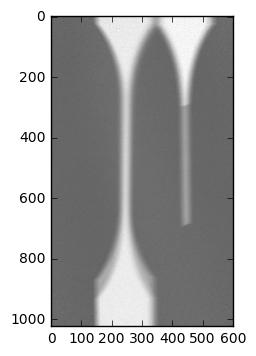

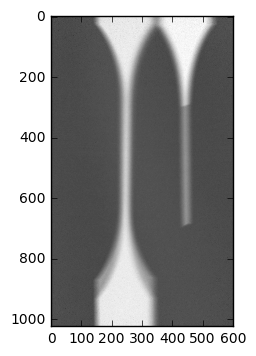

Image dimension is (1024, 600)
X is 1024 and Y is 600
(200, 1024, 600)


dtype('float64')

In [45]:
index = 80 #look at one fit file here
absFitsFiles = readFile(absFITS, "_abs_")
numFiles = len(absFitsFiles)
print (absFitsFiles[index])
oneImage = fits.open(absFitsFiles[index])
oneImage.info()
#oneImage.close()
oneImageArray = oneImage[0].data
oneImageArray.shape
oneImageArray = np.transpose(oneImageArray)
plt.imshow(oneImageArray, 'gray')
plt.show()

img = Image.fromarray(oneImageArray)
img = img.rotate(rotateAngle, resample=Image.BILINEAR, expand = False)
oneImageArray = np.array(img)
plt.imshow(oneImageArray, cmap='gray')
plt.show()

print ('Image dimension is', oneImageArray.shape)
[X, Y] = oneImageArray.shape
print ('X is', X, 'and Y is', Y)
allAbs = np.zeros((numFiles, X, Y)) #create abs volume
print (allAbs.shape)

for index in range(numFiles):
    oneImage = fits.open(absFitsFiles[index])
    oneImageArray = oneImage[0].data
    oneImageArray = np.transpose(oneImageArray)
    
    #image rotate
    img = Image.fromarray(oneImageArray)
    img = img.rotate(rotateAngle, resample=Image.BILINEAR, expand = False)
    oneImageArray = np.array(img)
    
    
    allAbs[index, :, :] = oneImageArray
#plt.imshow(allAbs[index, :, :], 'gray')
#plt.show()
allAbs.dtype

### read darkfield fits files and create dark volume

There are 200 _darkfield_ files
Filename: /run/media/tomouser/MercurySSD/HZB_Mar2017/Expt6_AM_TENS_Horiz_3D_v1/FITS/Expt6_AM_TENS_Horiz_3D_v1_darkfield_200.0.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (1024, 600)   float64   


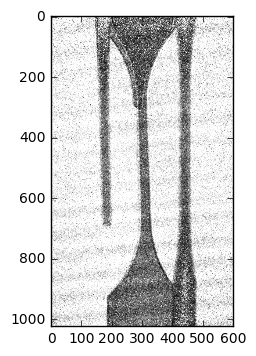

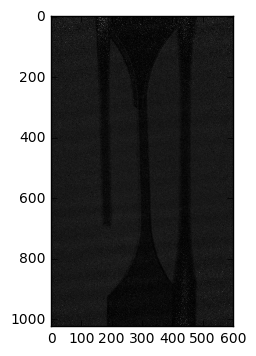

Image dimension is (1024, 600)
X is 1024 and Y is 600
(200, 1024, 600)


In [7]:
darkFitsFiles = readFile(darkFITS, "_darkfield_")
oneImage = fits.open(darkFitsFiles[index])
oneImage.info()
#oneImage.close()
oneImageArray = oneImage[0].data
oneImageArray.shape
oneImageArray = np.transpose(oneImageArray)
plt.imshow(oneImageArray, 'gray', vmin = 0, vmax=1)
plt.show()

img = Image.fromarray(oneImageArray)
img = img.rotate(rotateAngle, resample=Image.BILINEAR, expand = False)
oneImageArray = np.array(img)
plt.imshow(oneImageArray, cmap='gray')
plt.show()


print ('Image dimension is', oneImageArray.shape)
[X, Y] = oneImageArray.shape
print ('X is', X, 'and Y is', Y)
allDark = np.zeros((numFiles, X, Y))
print (allDark.shape)
for index in range(numFiles):
    oneImage = fits.open(darkFitsFiles[index])
    oneImageArray = oneImage[0].data
    oneImageArray = np.transpose(oneImageArray)
    
     #image rotate
    img = Image.fromarray(oneImageArray)
    img = img.rotate(rotateAngle, resample=Image.BILINEAR, expand = False)
    oneImageArray = np.array(img)
    
    allDark[index, :, :] = oneImageArray
#plt.imshow(allDark[index, :, :], 'gray',vmin =0, vmax = 1)
#plt.show()
allDark.dtype
allDark = 1 - allDark

### read dpc fits files

There are 200 _dpc_ files
Filename: /run/media/tomouser/MercurySSD/HZB_Mar2017/Expt6_AM_TENS_Horiz_3D_v1/FITS/Expt6_AM_TENS_Horiz_3D_v1_dpc_200.0.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   (1024, 600)   float64   


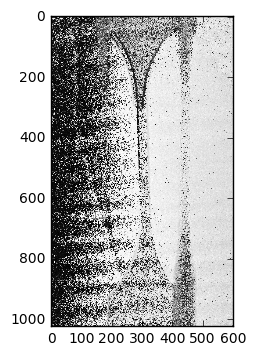

Image dimension is (1024, 600)
X is 1024 and Y is 600
(200, 1024, 600)


dtype('float64')

In [8]:
dpcFitsFiles = readFile(dpcFITS, "_dpc_")
oneImage = fits.open(dpcFitsFiles[index])
oneImage.info()
#oneImage.close()
oneImageArray = oneImage[0].data
oneImageArray.shape
oneImageArray = np.transpose(oneImageArray)
plt.imshow(oneImageArray, 'gray', vmin = -np.pi, vmax=np.pi)
plt.show()
print ('Image dimension is', oneImageArray.shape)
[X, Y] = oneImageArray.shape
print ('X is', X, 'and Y is', Y)
allDPC = np.zeros((numFiles, X, Y))
print (allDPC.shape)
for index in range(numFiles):
    oneImage = fits.open(dpcFitsFiles[index])
    oneImageArray = oneImage[0].data
    oneImageArray = np.transpose(oneImageArray)
    
    #image rotate
    img = Image.fromarray(oneImageArray)
    img = img.rotate(rotateAngle, resample=Image.BILINEAR, expand = False)
    oneImageArray = np.array(img)
    
    allDPC[index, :, :] = oneImageArray
#plt.imshow(allDPC[index, :, :], 'gray',vmin =-np.pi, vmax = np.pi)
#plt.show()
allDPC.dtype

### cropping images

In [46]:
#no needed here
absProj = allAbs
dpcProj = allDPC
darkProj = allDark
absProj.shape

(200, 1024, 600)

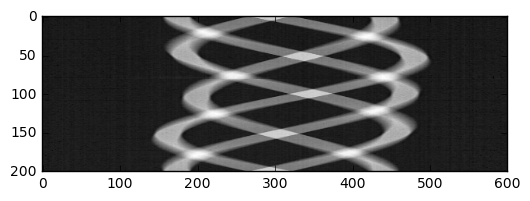

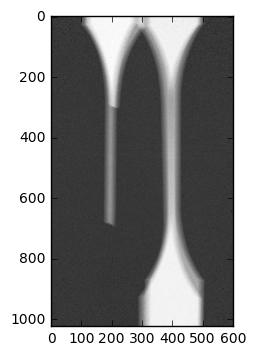

In [47]:
plt.imshow(absProj[:, 200, :], cmap='Greys_r')
plt.show()
plt.imshow(absProj[180, :, :], cmap='Greys_r')
plt.show()
#clear_output()

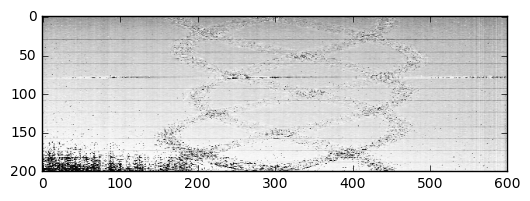

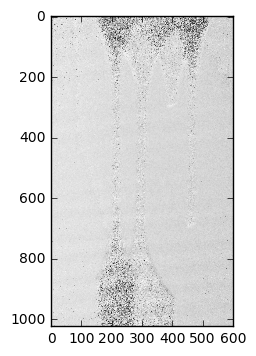

In [11]:
plt.imshow(dpcProj[:, 200, :], cmap='Greys_r', vmax = np.pi, vmin = -np.pi)
#plt.colorbar()
plt.show()
plt.imshow(dpcProj[90, :, :], cmap='Greys_r', vmax = np.pi, vmin = -np.pi)
#plt.colorbar()
plt.show()
#clear_output()

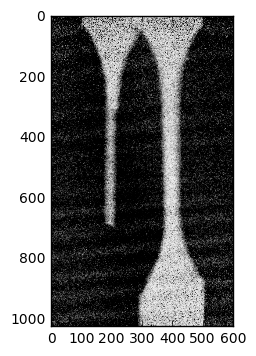

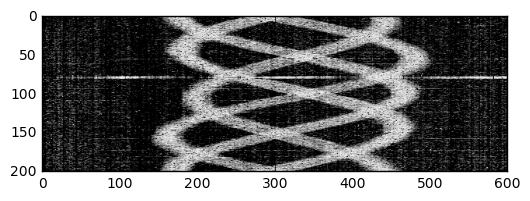

1.0
-20.1532058716


In [12]:
plt.imshow(darkProj[180, :, :], cmap='Greys_r', vmin = 0, vmax=1)
#plt.colorbar()
plt.show()
plt.imshow(darkProj[:, 200, :], cmap='Greys_r', vmin = 0, vmax=1)
#plt.colorbar()
plt.show()
print (np.max(darkProj))
print (np.min(darkProj))
#clear_output()

In [13]:
proj = dpcProj
print (np.max(proj))
print (np.min(proj))

listSampleAngles = np.zeros((np.int(360/par+1))) #0 degree to 360 degree
for i in range(len(listSampleAngles)):
    listSampleAngles[i] = i*par/180*np.pi
print ('There are', len(listSampleAngles), 'angles:', '\n\n', listSampleAngles)
numberOfAngles = len(listSampleAngles)
theta = listSampleAngles
360/(200.0-1)*np.pi/180
#clear_output()

3.14117383957
-3.14130067825
There are 200 angles: 

 [ 0.          0.0315738   0.06314759  0.09472139  0.12629518  0.15786898
  0.18944277  0.22101657  0.25259036  0.28416416  0.31573796  0.34731175
  0.37888555  0.41045934  0.44203314  0.47360693  0.50518073  0.53675452
  0.56832832  0.59990211  0.63147591  0.66304971  0.6946235   0.7261973
  0.75777109  0.78934489  0.82091868  0.85249248  0.88406627  0.91564007
  0.94721387  0.97878766  1.01036146  1.04193525  1.07350905  1.10508284
  1.13665664  1.16823043  1.19980423  1.23137803  1.26295182  1.29452562
  1.32609941  1.35767321  1.389247    1.4208208   1.45239459  1.48396839
  1.51554218  1.54711598  1.57868978  1.61026357  1.64183737  1.67341116
  1.70498496  1.73655875  1.76813255  1.79970634  1.83128014  1.86285394
  1.89442773  1.92600153  1.95757532  1.98914912  2.02072291  2.05229671
  2.0838705   2.1154443   2.14701809  2.17859189  2.21016569  2.24173948
  2.27331328  2.30488707  2.33646087  2.36803466  2.39960846  2.4311822

0.03157379551346526

## Delete bad fits files and corresponding angles (#79, 80, 81)

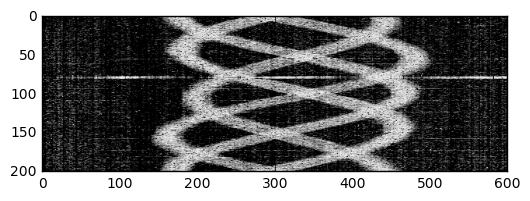

In [14]:
plt.imshow(darkProj[:, 200, :], cmap='Greys_r', vmin = 0, vmax=1)
#plt.colorbar()
plt.show()

In [15]:
allDark.shape, np.min(allDark), np.max(allDark), theta.shape

((200, 1024, 600), -20.153205871582031, 1.0, (200,))

In [16]:
theta2 = np.delete(theta, 79)
theta2 = np.delete(theta2, 80)
theta2 = np.delete(theta2, 81)
theta2.shape

(197,)

In [17]:
allDark = np.delete(allDark, 79, axis=0)
allDark = np.delete(allDark, 80, axis=0)
allDark = np.delete(allDark, 81, axis=0)
allDark.shape

(197, 1024, 600)

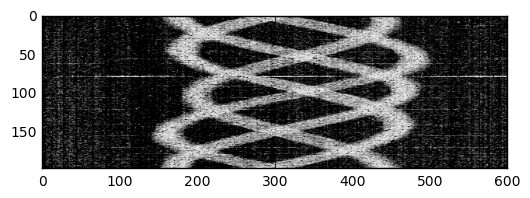

In [18]:
plt.imshow(allDark[:, 200, :], cmap='Greys_r', vmin = 0, vmax=1)
#plt.colorbar()
plt.show()

### find rotation center

In [48]:
rot_center = tomopy.find_center(allAbs, theta, init=236, ind=28, tol=0.5)
#proj = tomopy.minus_log(proj)
#remove outlier before recon
print (rot_center)

[ 320.8125]


In [49]:
#defined by yourself
rot_center = 319

## Step 4: TomoPy Reconstruction

In [35]:
np.min(absProj), np.max(absProj)

(-0.78570079803466797, 1.8007718324661255)

In [50]:
recon = tomopy.recon(absProj, theta, center=rot_center, algorithm='gridrec')
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

In [51]:
np.min(recon), np.max(recon), recon.shape

(-0.012993605, 0.0062288428, (1024, 600, 600))

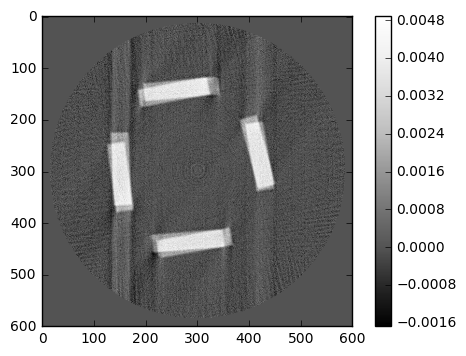

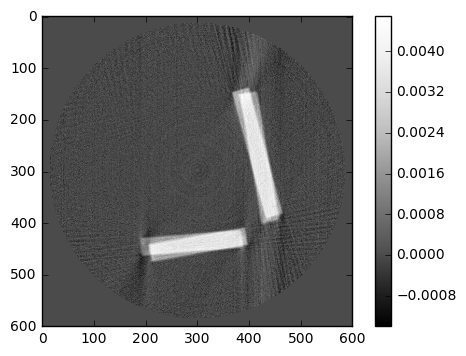

In [52]:
plt.imshow(recon[100, :,:], cmap='Greys_r')
plt.colorbar()
plt.show()
plt.imshow(recon[900, :,:], cmap='Greys_r')
plt.colorbar()
plt.show()

In [98]:
import h5py
with h5py.File(os.path.join(path, 'absRecon_Tomopy_Gridrec_extraAngle.h5'), 'w') as hf:
    hf.create_dataset('slice', data=recon)

In [99]:
darkProj = allDark
recon = tomopy.recon(darkProj, theta2, center=rot_center, algorithm='gridrec')
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

In [86]:
recon.shape

(1024, 600, 600)

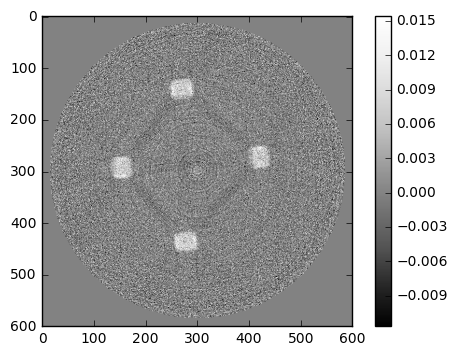

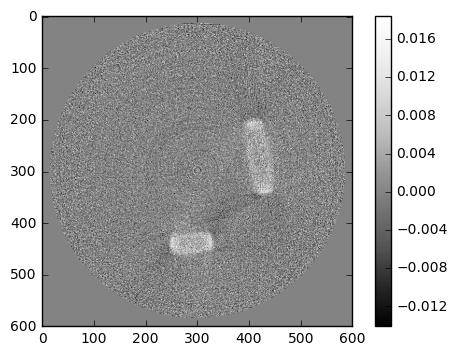

In [87]:
plt.imshow(recon[250, :,:], cmap='Greys_r')
plt.colorbar()
plt.show()
plt.imshow(recon[800, :,:], cmap='Greys_r')
plt.colorbar()
plt.show()

In [88]:
import h5py
with h5py.File(os.path.join(workdir, 'darkRecon_Tomopy_Gridrec.h5'), 'w') as hf:
    hf.create_dataset('slice', data=recon)

In [89]:
recon = tomopy.recon(dpcProj, theta, center=rot_center, algorithm='gridrec')
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

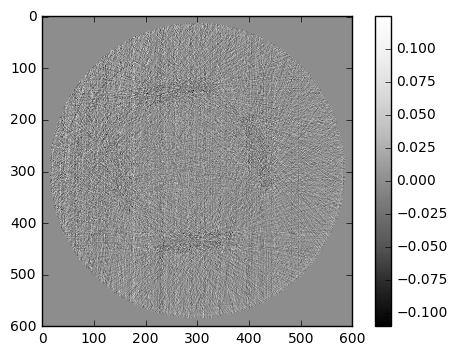

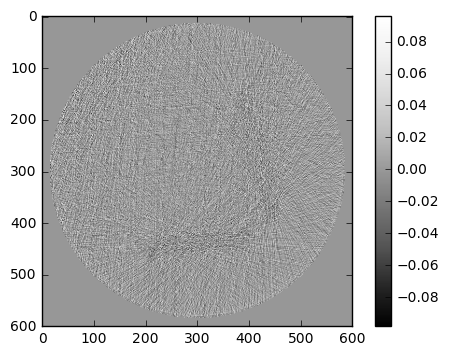

In [90]:
plt.imshow(recon[100, :,:], cmap='Greys_r')
plt.colorbar()
plt.show()
plt.imshow(recon[900, :,:], cmap='Greys_r')
plt.colorbar()
plt.show()

In [91]:
#save the reconstructed volume
import h5py
with h5py.File(os.path.join(workdir, 'dpcRecon_Tomopy_Gridrec.h5'), 'w') as hf:
    hf.create_dataset('slice', data=recon)

## Step 5: ASTRA Reconstruction

### Step 5.1 sirt for dpc

In [31]:
#tomopy.astra?
extra_options ={'MinConstraint':-np.pi}
options = {'proj_type':'cuda', 'method':'SIRT_CUDA', 'num_iter':40,'extra_options':extra_options}
dpcRecon = tomopy.recon(dpcProj, theta, center=rot_center, algorithm=tomopy.astra, options=options)
dpcRecon = tomopy.circ_mask(dpcRecon, axis=0, ratio=0.85)

Exception: The dimensions of the data do not match those specified in the geometry.

In [ ]:
plt.imshow(dpcRecon[100, :,:], cmap='Greys_r', vmin = np.min(dpcRecon)/2, vmax = np.max(dpcRecon)/2)
plt.colorbar()
plt.show()
plt.imshow(dpcRecon[900, :,:], cmap='Greys_r', vmin = np.min(dpcRecon)/2, vmax = np.max(dpcRecon)/2)
plt.colorbar()
plt.show()

In [ ]:
import h5py
with h5py.File(os.path.join(path, 'dpcRecon_Astra_SIRT_CUDA_iter40.h5'), 'w') as hf:
    hf.create_dataset('slice', data=dpcRecon)

### sirt for dark-field

In [ ]:
#tomopy.astra?
extra_options ={'MinConstraint':-0.5}
options = {'proj_type':'cuda', 'method':'SIRT_CUDA', 'num_iter':40,'extra_options':extra_options}
darkRecon = tomopy.recon(darkProj, theta, center=rot_center, algorithm=tomopy.astra, options=options)
darkRecon = tomopy.circ_mask(darkRecon, axis=0, ratio=0.85)

In [ ]:
plt.imshow(darkRecon[100, :,:], cmap='Greys_r')
plt.colorbar()
plt.show()
plt.imshow(darkRecon[900, :,:], cmap='Greys_r')
plt.colorbar()
plt.show()

In [ ]:
import h5py
with h5py.File(os.path.join(workdir, 'darkRecon_Astra_SIRT_CUDA_iter40.h5'), 'w') as hf:
    hf.create_dataset('slice', data=darkRecon)

### sirt for absorption

In [ ]:
#tomopy.astra?
extra_options ={'MinConstraint':-0.1}
options = {'proj_type':'cuda', 'method':'SIRT_CUDA', 'num_iter':40,'extra_options':extra_options}
absRecon = tomopy.recon(absProj, theta, center=rot_center, algorithm=tomopy.astra, options=options)
absRecon = tomopy.circ_mask(absRecon, axis=0, ratio=0.85)

In [ ]:
plt.imshow(absRecon[100, :,:], cmap='Greys_r', vmin = np.min(absRecon), vmax = np.max(absRecon))
plt.colorbar()
plt.show()
plt.imshow(absRecon[900, :,:], cmap='Greys_r', vmin = np.min(absRecon), vmax = np.max(absRecon))
plt.colorbar()
plt.show()

In [ ]:
import h5py
with h5py.File(os.path.join(path, 'absRecon_Astra_SIRT_CUDA_iter40.h5'), 'w') as hf:
    hf.create_dataset('slice', data=absRecon)